In [5]:
%pylab inline
import numpy as np 
import pandas as pd
import seaborn as sns
import string

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import preprocess_string
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.matutils import corpus2csc, corpus2dense

Populating the interactive namespace from numpy and matplotlib


# Data Preprocessing

- 약 13.5% 만이 spam으로 분류되어 있다. 즉 class imbalance 문제가 있다.
- unique 메세지를 보면 duplicate text가 존재함을 알 수 있다.

In [2]:
data = pd.read_csv('spam.csv', encoding='latin-1', usecols=(0, 1), names=('class', 'text'), skiprows=1)
display(data.head())
display(data.groupby('class').describe())

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


text                                                               
      count unique                                                top freq
class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

아래의 histogram에서 알 수 있듯이, 대부분의 Ham의 글자길이는 대부분 100이하에 있고, Spam의 경우는 150쯤에 있습니다.<br>
즉 길이의 차이가 있으며, Spam이 문장의 길이가 더 깁니다.

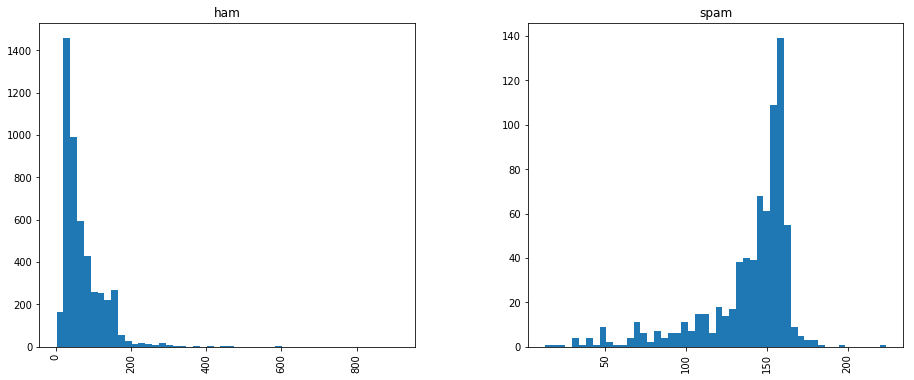

In [3]:
data['length'] = data['text'].apply(len)
ax = data.hist('length', by='class', bins=50, figsize=(15, 6))

# Preprocessing

In [6]:
def process_text(text):
    text = remove_stopwords(text)
    text = preprocess_string(text)
    return text

data['text'] = data['text'].apply(process_text)
display(data['text'].head(5))

0    [jurong, point, crazi, avail, bugi, great, wor...
1                                [lar, joke, wif, oni]
2    [free, entri, wkly, comp, win, cup, final, tkt...
3                                    [dun, earli, hor]
4                         [nah, think, goe, usf, live]
Name: text, dtype: object

In [7]:
texts = data['text'].tolist()
train_x, test_x, train_y, test_y = train_test_split(texts, data['class'], 
                                                    test_size=0.2)

## Dictionary

In [8]:
dictionary = Dictionary()
[dictionary.add_documents([text]) for text in train_x]
dictionary.filter_extremes(keep_n=20000)
dictionary.token2id

{'friend': 0,
 'afternoon': 1,
 'babe': 2,
 'fine': 3,
 'funni': 4,
 'movi': 5,
 'saw': 6,
 'tho': 7,
 'town': 8,
 'want': 9,
 'yest': 10,
 'chat': 11,
 'cheap': 12,
 'choos': 13,
 'connect': 14,
 'girl': 15,
 'hard': 16,
 'live': 17,
 'min': 18,
 'servic': 19,
 'lesson': 20,
 'practic': 21,
 'start': 22,
 'take': 23,
 'fri': 24,
 'leh': 25,
 'lor': 26,
 'said': 27,
 'wait': 28,
 'bath': 29,
 'cup': 30,
 'drink': 31,
 'know': 32,
 'need': 33,
 'night': 34,
 'warm': 35,
 'work': 36,
 'boytoi': 37,
 'get': 38,
 'hello': 39,
 'job': 40,
 'lazi': 41,
 'miss': 42,
 'net': 43,
 'nice': 44,
 'readi': 45,
 'lover': 46,
 'noon': 47,
 'sure': 48,
 'gonna': 49,
 'normal': 50,
 'see': 51,
 'sorri': 52,
 'time': 53,
 'tuesdai': 54,
 'believ': 55,
 'dun': 56,
 'muz': 57,
 'thk': 58,
 'told': 59,
 'tot': 60,
 'true': 61,
 'didnt': 62,
 'fix': 63,
 'good': 64,
 'goodnight': 65,
 'sleep': 66,
 'wake': 67,
 'plai': 68,
 'credit': 69,
 'detail': 70,
 'free': 71,
 'great': 72,
 'hous': 73,
 'offer': 74,
 

In [9]:
train_corpus = [dictionary.doc2bow(text) for text in train_x]
test_corpus = [dictionary.doc2bow(text) for text in test_x]
print(train_corpus[0])
print(train_corpus[1])
print(train_corpus[3])

[(0, 2)]
[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]
[(20, 1), (21, 1), (22, 1), (23, 1)]


## TF-IDF

In [26]:
tfidf = TfidfModel(train_corpus)
train_sparse_matrix = corpus2csc(tfidf[train_corpus]).T
test_sparse_matrix = corpus2csc(tfidf[test_corpus], train_sparse_matrix.shape[1]).T

print('train_sparse_matrix:', train_sparse_matrix.shape)
print('test_sparse_matrix:', test_sparse_matrix.shape)

train_sparse_matrix: (4457, 1114)
test_sparse_matrix: (1115, 1114)


# Naive Bayes Model

             precision    recall  f1-score   support

        ham       0.97      0.99      0.98       947
       spam       0.97      0.85      0.90       168

avg / total       0.97      0.97      0.97      1115



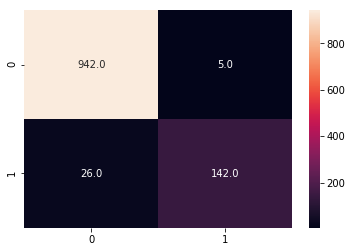

In [35]:
nb = MultinomialNB()
nb.fit(train_sparse_matrix, train_y)

pred_y = nb.predict(test_sparse_matrix)
print(classification_report(test_y, pred_y))
sns.heatmap(confusion_matrix(test_y, pred_y), fmt='.1f', annot=True)

# Logistic Regression Model

             precision    recall  f1-score   support

        ham       0.96      1.00      0.98       947
       spam       0.97      0.75      0.85       168

avg / total       0.96      0.96      0.96      1115



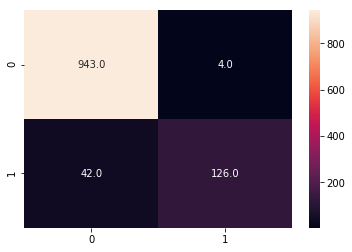

In [33]:
lr = LogisticRegression()
lr.fit(train_sparse_matrix, train_y)

pred_y = lr.predict(test_sparse_matrix)
print(classification_report(test_y, pred_y))
sns.heatmap(confusion_matrix(test_y, pred_y), fmt='.1f', annot=True)